In [1]:

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)

import yaml


/home/saurabh.nair/giant_nerfs/pytorch-superpoint-new


In [2]:
from models.model_wrap import SuperPointFrontend_torch

In [3]:
config_path = os.path.expanduser("~/giant_nerfs/pytorch-superpoint-new/configs/giant_exps.yaml")
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
print(config)
weights_path = config["model"]["pretrained"]
nms_dist = config["model"]["nms"]
conf_thresh = config["model"]["detection_threshold"]
nn_thresh = 0.7
device = 'cuda'

{'data': {'name': 'patches_dataset', 'dataset': 'hpatches', 'alteration': 'all', 'preprocessing': {'resize': [240, 320]}}, 'front_end_model': 'Val_model_heatmap', 'model': {'name': 'SuperPointNet_gauss2', 'params': {}, 'detection_threshold': 0.015, 'batch_size': 1, 'eval_batch_size': 1, 'learning_rate': 0.001, 'nms': 4, 'top_k': 1000, 'nn_thresh': 1.0, 'homography_adaptation': {'num': 0}, 'subpixel': {'enable': False, 'patch_size': 5}, 'rand_noise': {'enable': False, 'sigma': 0.2}, 'pretrained': '/scratch/aiscience/logs/superpoint/superpoint_coco/checkpoints/superPointNet_189800_checkpoint.pth.tar'}, 'eval_iter': 1000}


In [4]:
sp_fe = SuperPointFrontend_torch(
    config=config,
    weights_path=weights_path,
    nms_dist=nms_dist,
    conf_thresh=conf_thresh,
    nn_thresh=nn_thresh,
    cuda=False,
    device=device,
)

sp_fe.net_parallel()

model:  SuperPointNet_gauss2
=== Let's use 3 GPUs!


In [5]:
from PIL import Image
import numpy as np

In [6]:
image_data_path = "/scratch/aiscience/data/combined_setx/set_0/images/"

In [7]:
rgb_img = Image.open(os.path.join(image_data_path, "IMG_2044.jpg"))
img = rgb_img.convert('L')
newsize = (1280, 960)
img = img.resize(newsize)

In [8]:
image_np = np.asarray(img) / 255.0


In [9]:
import torch

In [10]:
image_torch = torch.from_numpy(image_np)

In [11]:
image_torch = image_torch.transpose(1, 0)

In [12]:
image_torch = image_torch[None, None, :]
image_torch = image_torch.to(device, dtype=torch.float)

In [13]:
output = sp_fe.run(image_torch, onlyHeatmap=True, train=False)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [14]:
output_heatmap = output.to("cpu").numpy()

output_heatmap = np.squeeze(output_heatmap, axis=0)
output_heatmap = np.squeeze(output_heatmap, axis=0)

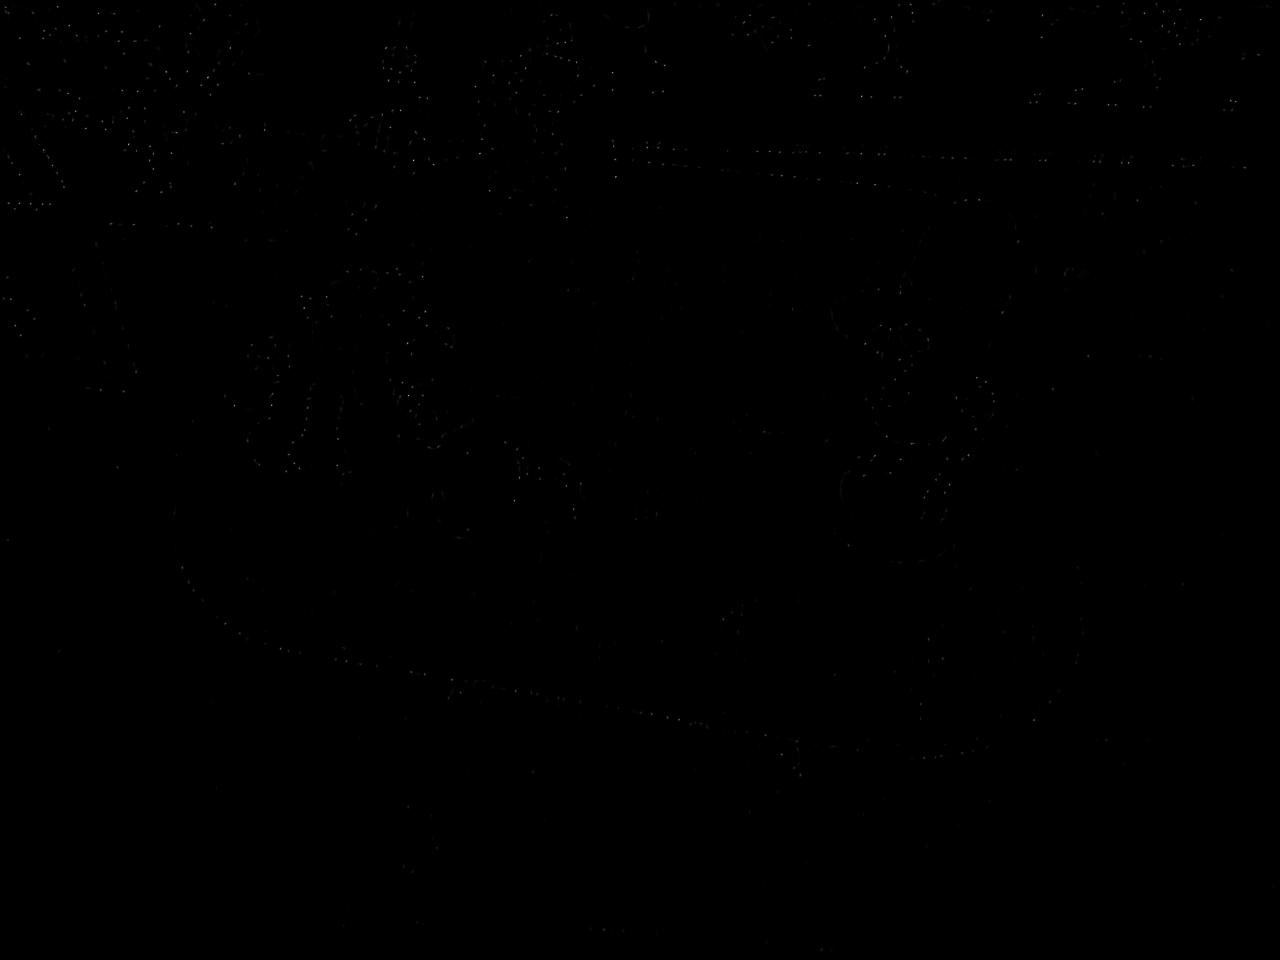

In [15]:
Image.fromarray(np.uint8(output_heatmap * 255).T, "L")

In [16]:
keypoint_locations = sp_fe.getPtsFromHeatmap(output.detach().cpu().squeeze())

In [17]:
keypoint_locations = keypoint_locations.transpose()

In [18]:
#rgb_img
newsize = (1280, 960)
rgb_img = rgb_img.resize(newsize)

In [19]:
keypoint_locations.shape

(1330, 3)

In [20]:
keypoint_locations[4]

array([1.90000000e+01, 1.20000000e+03, 5.82321584e-01])

In [39]:
rgb_img_array = np.array(rgb_img)
blob_size = 1
blob = np.tile(np.array([0., 255, 0.]), (2*blob_size, 2*blob_size, 1))
for keypoint_location in keypoint_locations:
    rgb_img_array[
        int(keypoint_location[0]) - blob_size:int(keypoint_location[0]) + blob_size, 
        int(keypoint_location[1]) - blob_size:int(keypoint_location[1]) + blob_size
    ] = blob

In [40]:
rgb_img_with_pts = Image.fromarray(rgb_img_array)

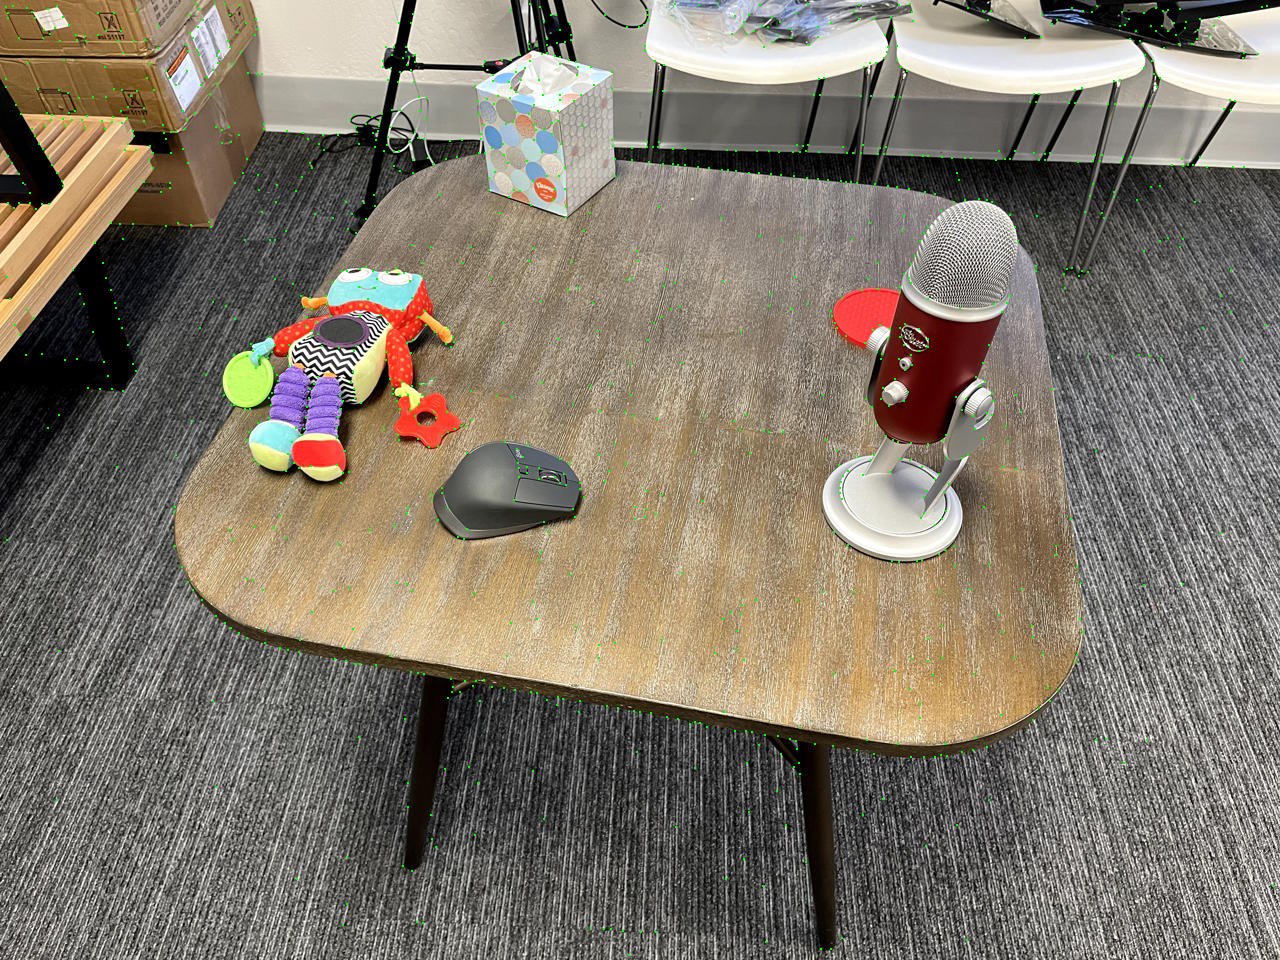

In [41]:
rgb_img_with_pts

In [24]:
output = sp_fe.run(image_torch, onlyHeatmap=False, train=False)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [25]:
pts, pts_desc, dense_desc, heatmap = output

In [26]:
pts_desc[0].shape

(256, 1330)

In [27]:
from models.model_wrap import PointTracker

In [28]:
matcher = PointTracker(nn_thresh=2.0)

In [43]:
pts_desc_0 = pts_desc[0]
pts_desc_1 = pts_desc[0]
matches = matcher.nn_match_two_way(pts_desc_0, pts_desc_1, nn_thresh=2.0)

In [78]:
# Just append the pixes keypoint locations 
keypoints_matches_loc = []
pts0 = pts[0]
pts1 = pts[0]

for match in matches.T:
    #current_match_locs = np.uint8(pts[0].T[int(match[0])][:2]).tolist()
    #current_match_locs.extend(np.uint8(pts[0].T[int(match[0])][:2]).tolist())\
    #print(match)
    current_match_locs = [
        int(pts0.T[int(match[0])][1]), 
        int(pts0.T[int(match[0])][0]), 
        int(pts1.T[int(match[1])][1]), 
        int(pts1.T[int(match[1])][0])
    ]
    keypoints_matches_loc.append(current_match_locs)
    
#print(keypoints_matches_loc)

In [79]:
matches[:, -1]

array([1329., 1329.,    0.])

In [80]:
from evaluation import draw_matches_cv

In [ ]:
disp_img = np.uint8(np.asarray(rgb_img.convert('L'))*255)
#disp_img = np.asarray(rgb_img)


data = dict(matches=keypoints_matches_loc, image1=disp_img, image2=disp_img)
matches_display = draw_matches_cv(data=data, matches=None, plot_points=False)

matches_pts: [[413, 160, 413, 160], [408, 395, 408, 395], [128, 144, 128, 144], [861, 96, 861, 96], [1200, 19, 1200, 19], [400, 110, 400, 110], [612, 72, 612, 72], [271, 405, 271, 405], [407, 343, 407, 343], [207, 77, 207, 77], [433, 164, 433, 164], [69, 25, 69, 25], [479, 153, 479, 153], [514, 500, 514, 500], [19, 203, 19, 203], [190, 33, 190, 33], [388, 80, 388, 80], [647, 147, 647, 147], [234, 405, 234, 405], [98, 13, 98, 13], [664, 65, 664, 65], [425, 311, 425, 311], [137, 91, 137, 91], [19, 174, 19, 174], [565, 42, 565, 42], [475, 86, 475, 86], [390, 127, 390, 127], [424, 139, 424, 139], [1235, 101, 1235, 101], [30, 203, 30, 203], [1042, 15, 1042, 15], [489, 190, 489, 190], [422, 276, 422, 276], [566, 217, 566, 217], [857, 183, 857, 183], [176, 132, 176, 132], [414, 82, 414, 82], [153, 153, 153, 153], [861, 153, 861, 153], [615, 159, 615, 159], [1144, 13, 1144, 13], [166, 71, 166, 71], [171, 153, 171, 153], [122, 90, 122, 90], [68, 93, 68, 93], [558, 111, 558, 111], [576, 62, 576,

ipdb> matches
ipdb> matches.shape
*** AttributeError: 'NoneType' object has no attribute 'shape'


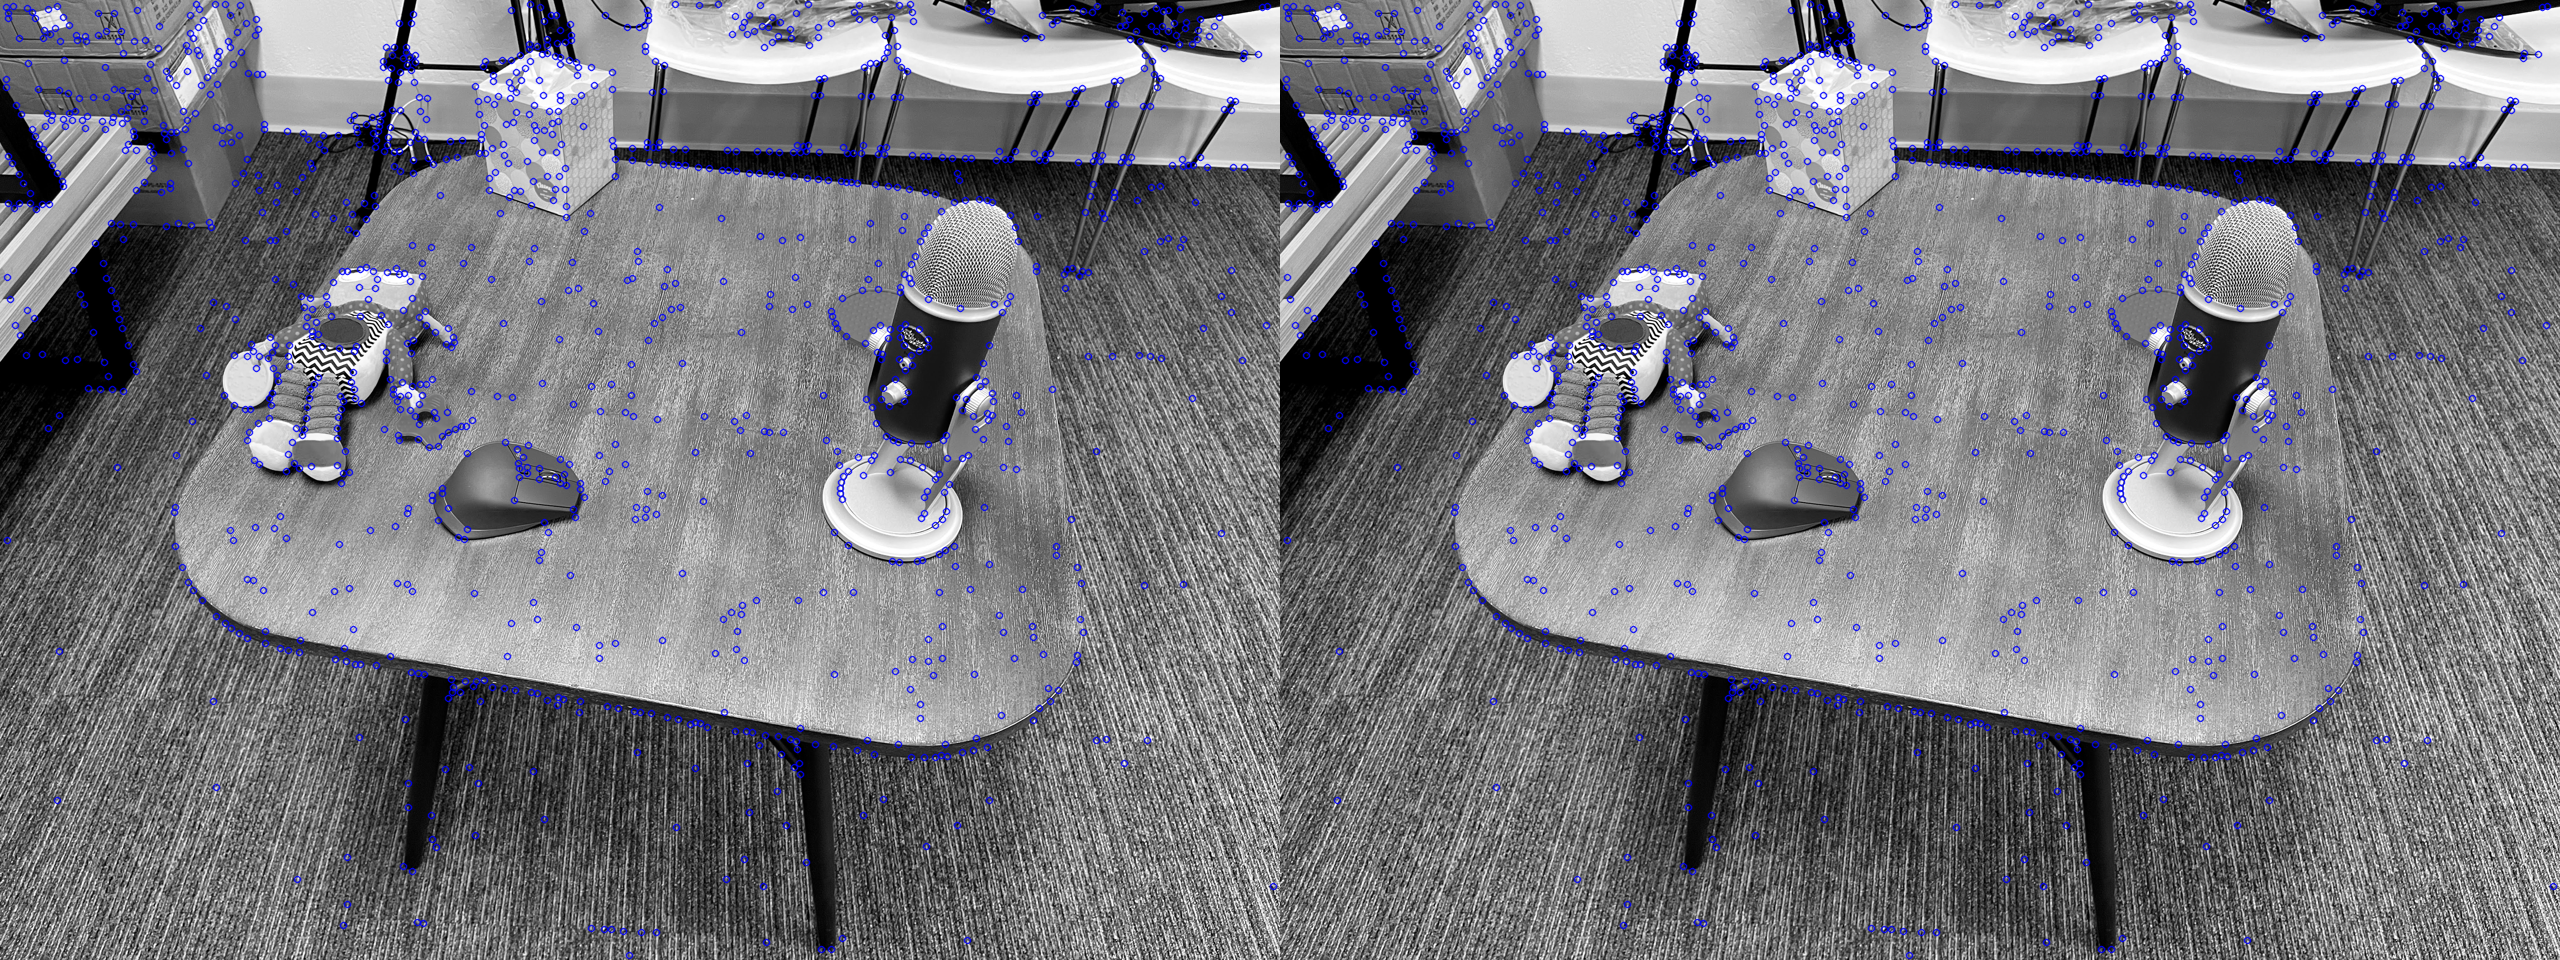

In [82]:
Image.fromarray(matches_display)

In [ ]:
matches_display

In [37]:
matches.T.shape

(1330, 3)